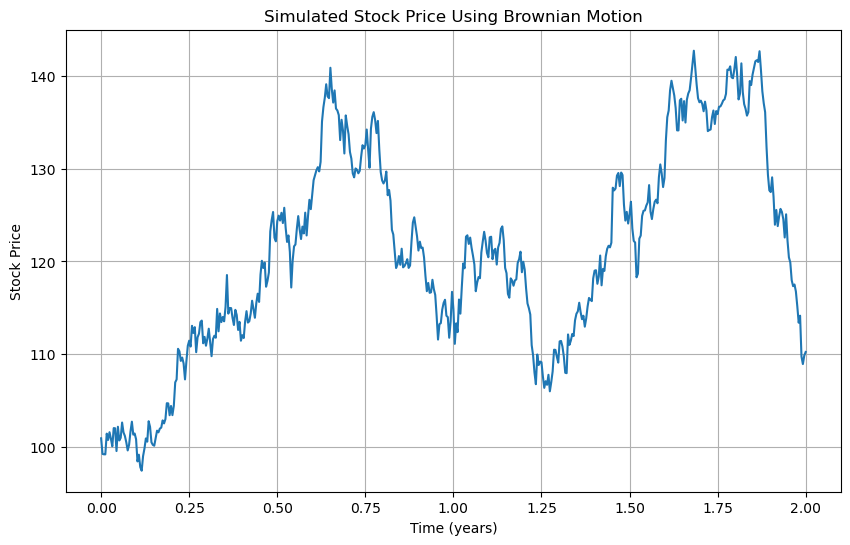

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from Stock_movement import StockMovement

duration = 2 # years
dt = 1/252 # years
volatility = 0.2
mean_return = 0.1
stock = StockMovement(100, duration, dt, volatility, mean_return)

stock.get_prices()

# Plot the simulated stock price
plt.figure(figsize=(10, 6))
plt.plot(stock.time, stock.prices)
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.title('Simulated Stock Price Using Brownian Motion')
plt.grid(True)
plt.show()
